In [54]:
# Make plots in the notebook so you can see them.
%matplotlib inline
#! python -m pip install lightkurve --upgrade
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation as mad
from scipy.optimize import curve_fit

import lightkurve # Import the lightkurve library
from lightkurve import search_targetpixelfile # From the lightkurve library, import the search_targetpixelfile method.

In [55]:
# Set up needed methods

def Carter_model(time, tc, f0, delta, T, tau):
    # tc - central transit time
    # f0 - out-of-transit baseline
    # delta - f0*r**2
    # T - 2*tau0*sqrt(1-b**2)
    # tau = 2*tau0*r**2/sqrt(1 - b**2)

    flux = np.zeros_like(time)

    ind = np.abs(time - tc) <= (T/2. - tau/2.)
    if(len(time[ind]) > 0):
        flux[ind] = f0 - delta

    ind = ((T/2. - tau/2.) < np.abs(time - tc)) & ((T/2. + tau/2.) > np.abs(time - tc))
    if(len(time[ind]) > 0):
        flux[ind] = f0 - delta + (delta/tau)*(np.abs(time[ind] - tc) - T/2. + tau/2.)

    ind = np.abs(time - tc) >= (T/2. + tau/2.)
    if(len(time[ind]) > 0):
        flux[ind] = f0

    return flux

def get_planet_lightcurve(planet_name):
    # Open a Target Pixel File from MAST and download one data file.
    tpf = search_targetpixelfile(planet_name).download()

    # Then we convert the target pixel file into a light curve using the pipeline-defined aperture mask.
    lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask).remove_nans()

    time, flux = lc.time.value, lc.flux.value

    return time, flux

def calc_detrended_flux(time, flux, coeffs):
    return (flux - np.polyval(coeffs, time))/np.polyval(coeffs, time)

def calc_sigma(detrended_flux):
    # Use the standard deviation of all the data to estimate the uncertainty
    return np.ones_like(detrended_flux)*mad(detrended_flux)

def fit_transit_ephemeris(time, trial_T0, trial_period):
    # Phase fold on the trial period
    folded_time = ((time - trial_T0) % trial_period)

    ret_val = Carter_model(folded_time, trial_T0, *transit_shape_params[1:])

    return ret_val

/usr/local/lib/python3.10/dist-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


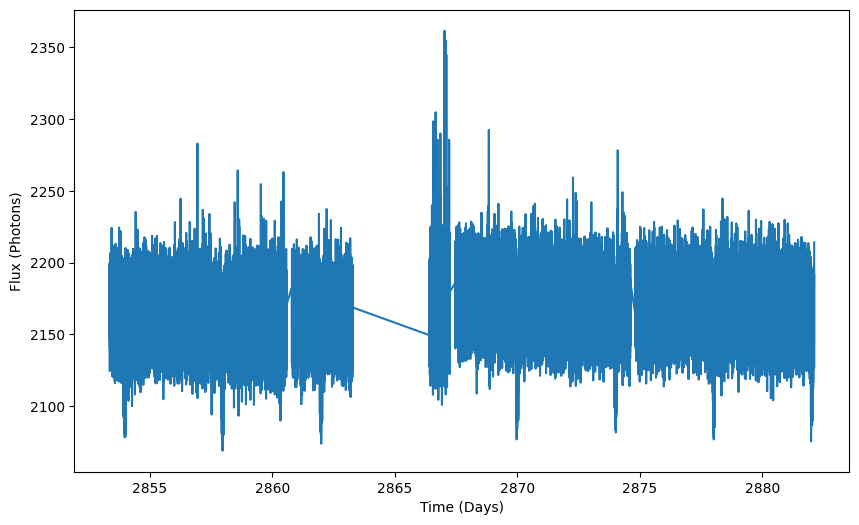

In [56]:
# Give your planet name - be sure to spell everything exactly right. Otherwise, the package won't find the data.
planet_name = "HAT-P-19"

#orbital_period = 3.0300737 # https://en.wikipedia.org/wiki/TrES-2b
#orbital_period = 3.0927616 # https://en.wikipedia.org/wiki/WASP-10b
#orbital_period = 1.482247063 # https://en.wikipedia.org/wiki/GSC_03949-00967
#orbital_period = 3.94150685 # https://en.wikipedia.org/wiki/XO-1b
orbital_period = 4.0087780

time, flux = get_planet_lightcurve(planet_name)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(time, flux)

x_label_text = "Time (Days)" # Label your x-axis
y_label_text = "Flux (Photons)" # Label your y-axis
ax.set_xlabel(x_label_text)
ax.set_ylabel(y_label_text)

# Save your figure - use another name that describes the data plotted
figure_name = "lightcurve.png"
fig.savefig(figure_name, dpi=300, bbox_inches="tight")

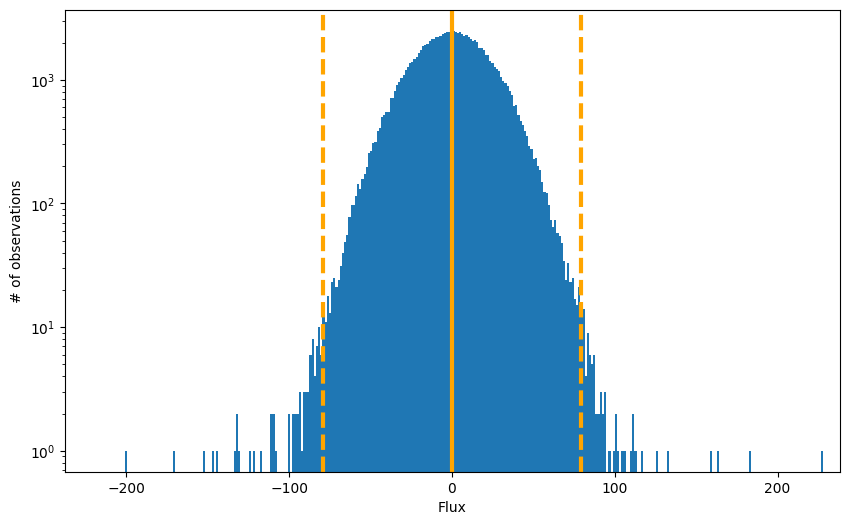

In [57]:
# Calculate the derivative
df = np.diff(flux)
num_sigma = 5.

# Calculate the median value
med = np.median(df)
# Calculate the standard deviation
std = mad(df)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

# Make a histogram showing the distribution of derivative values.
ax.hist(df, bins='auto');
ax.set_yscale('log') # Make it easier to the outliers

# Add in lines showing the expected width of the distribution if it were just Gaussian.
ax.axvline(med, lw=3, color='orange')
ax.axvline(med - num_sigma*std, lw=3, color='orange', ls='--')
ax.axvline(med + num_sigma*std, lw=3, color='orange', ls='--')

ax.set_xlim([-3*num_sigma*std + med, 3*num_sigma*std + med])

x_label_text = "Flux" # Label your x-axis
y_label_text = "# of observations" # Label your y-axis
ax.set_xlabel(x_label_text)
ax.set_ylabel(y_label_text)

# Save your figure - use another name that describes the data plotted
figure_name = "distribution.png"
fig.savefig(figure_name, dpi=300, bbox_inches="tight")

/usr/local/lib/python3.10/dist-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


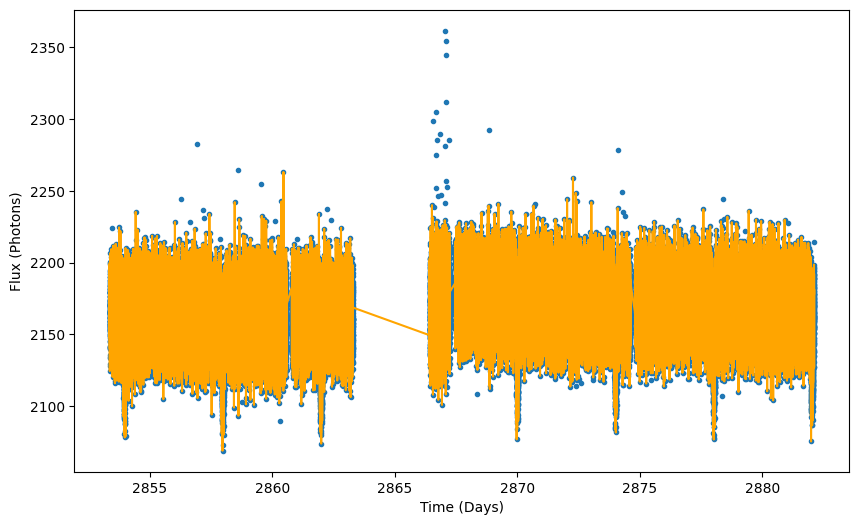

In [58]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

# Let's compare the original data with outliers to the processed data with outliers removed.
time, flux = get_planet_lightcurve(planet_name)
ax.plot(time, flux, marker='.', ls='')

# Find the outlier points
df = np.diff(flux)
ind = np.abs(df - med) > num_sigma*std

# Append one extra element - we have to re-jigger the data a bit since diff returns one fewer element.
ind = np.append(ind, False)
time = time[~ind][:-2]
flux = flux[~ind][:-2]
ax.plot(time, flux, color='orange')

x_label_text = "Time (Days)" # Label your x-axis
y_label_text = "Flux (Photons)" # Label your y-axis
ax.set_xlabel(x_label_text)
ax.set_ylabel(y_label_text)

# Save your figure - use another name that describes the data plotted
figure_name = "non_outliers.png"
fig.savefig(figure_name, dpi=300, bbox_inches="tight")

<ipython-input-59-7327f3ed6096>:15: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(time[~ind], flux[~ind], polynomial_degree)


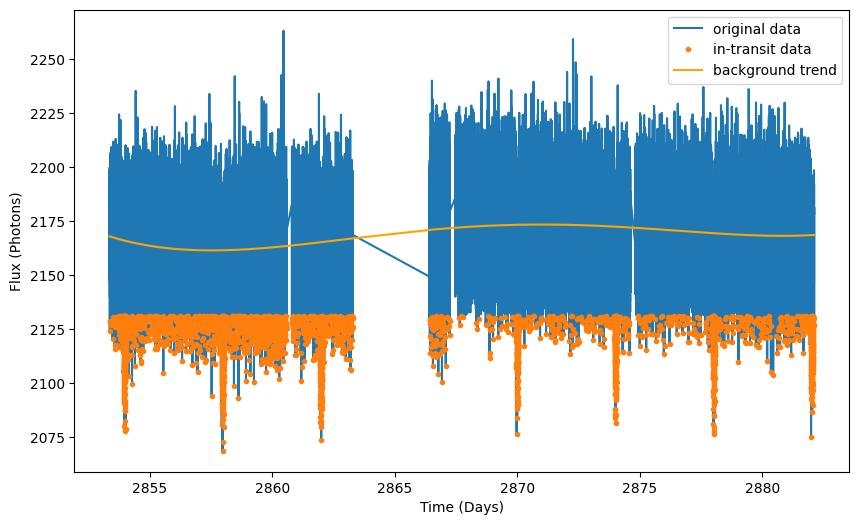

In [59]:
num_sigma = 3.
polynomial_degree = 8

med = np.median(flux)
std = mad(flux)
ind = (med - flux) > num_sigma*std

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

ax.plot(time, flux, label="original data")
plt.plot(time[ind], flux[ind], ls='', marker='.', label="in-transit data")

# Fit a polynomial
coeffs = np.polyfit(time[~ind], flux[~ind], polynomial_degree)
detrended_flux = calc_detrended_flux(time, flux, coeffs)

ax.plot(time, np.polyval(coeffs, time), color='orange', label="background trend")
ax.legend(loc='best')

x_label_text = "Time (Days)" # Label your x-axis
y_label_text = "Flux (Photons)" # Label your y-axis
ax.set_xlabel(x_label_text)
ax.set_ylabel(y_label_text)

# Save your figure - use another name that describes the data plotted
figure_name = "highpass_filter.png"
fig.savefig(figure_name, dpi=300, bbox_inches="tight")

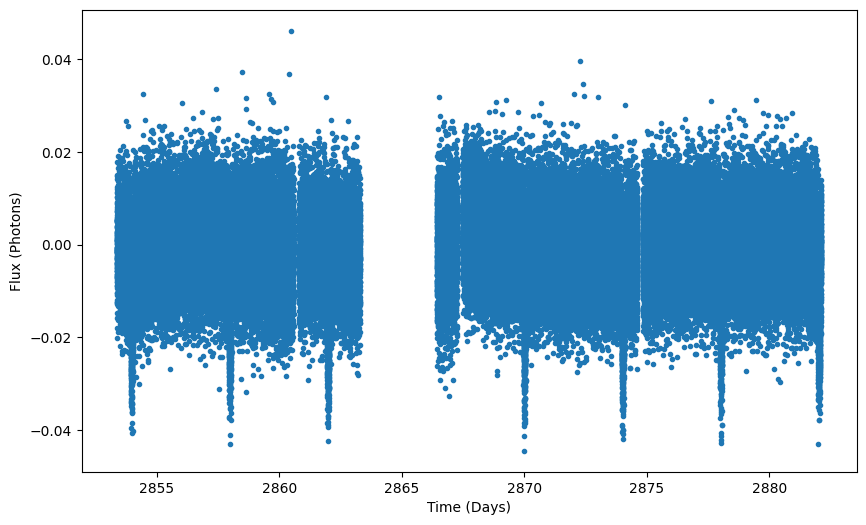

In [60]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

# And now let's plot the detrended/outlier-filtered data
ax.scatter(time, detrended_flux, marker='.')

x_label_text = "Time (Days)" # Label your x-axis
y_label_text = "Flux (Photons)" # Label your y-axi
ax.set_xlabel(x_label_text)
ax.set_ylabel(y_label_text)

# Save your figure - use another name that describes the data plotted
figure_name = "remove_background.png"
fig.savefig(figure_name, dpi=300, bbox_inches="tight")

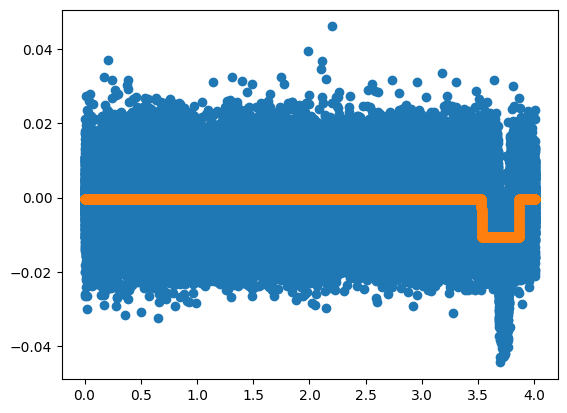

In [61]:
# Phase-folded time
folded_time = (time % orbital_period)
# Detrend the flux
detrended_flux = calc_detrended_flux(time, flux, coeffs)

# The background value is very nearly the median for all the data
background = np.median(detrended_flux)

# ratio of the planet's to the star's radius - usually about 0.1
ratio_of_planet_to_star_radius = 0.1

# Let's guess that the central transit time is the time when the flux drops to its minimum value
t0 = (time % orbital_period)[np.argmin(detrended_flux)]

# transit duration - probably a few hours, but be sure to tweak it to what your eyeball says
duration = 4./24. # Divide through 24 hours to convert from hours to days.

# Let's set our initial guesses and check them
initial_guesses = np.array([t0, background, ratio_of_planet_to_star_radius**2,
                            2.*duration, 2.*duration*ratio_of_planet_to_star_radius**2])

plt.scatter(folded_time, detrended_flux)
plt.scatter(folded_time, Carter_model(folded_time, *initial_guesses))

best fit values: 3.72821, -0.000187296, 0.02081, 0.0941803, 0.0205044
best fit uncertainties: 0.000214478, 2.37378e-05, 0.000164315, 0.000458474, 0.00075894


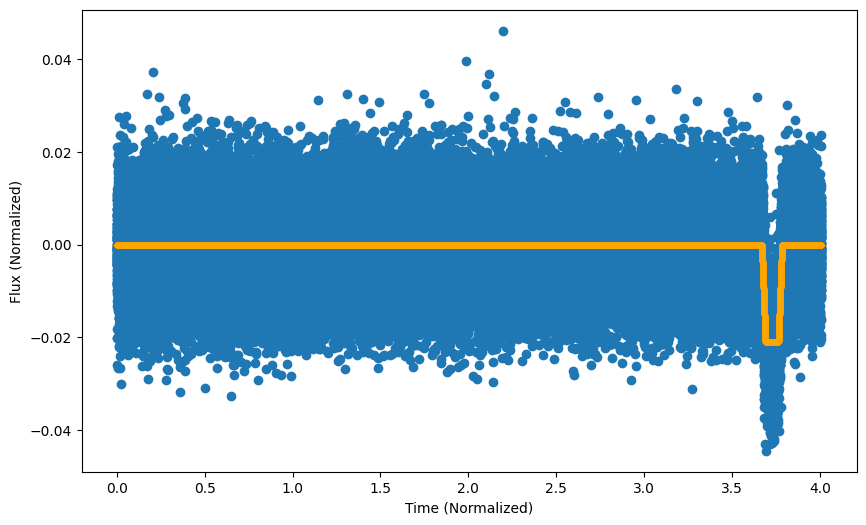

In [68]:
# Reset initial guesses
initial_guesses = np.array([t0, background, ratio_of_planet_to_star_radius,
                            2.*duration, 2.*duration*ratio_of_planet_to_star_radius**2])

# Estimate per-point uncertainties
sigma = calc_sigma(detrended_flux)

# Fit folded transit
transit_shape_params, pcov = curve_fit(Carter_model, folded_time, detrended_flux,
                      p0=initial_guesses, sigma=sigma)
transit_shape_params_unc = np.sqrt(np.diag(pcov))
print("best fit values: %g, %g, %g, %g, %g" %\
      (transit_shape_params[0],
       transit_shape_params[1],
       transit_shape_params[2],
       transit_shape_params[3],
       transit_shape_params[4]))
print("best fit uncertainties: %g, %g, %g, %g, %g" % (transit_shape_params_unc[0],
                                                      transit_shape_params_unc[1],
                                                      transit_shape_params_unc[2],
                                                      transit_shape_params_unc[3],
                                                      transit_shape_params_unc[4]))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

# Check the fit
ax.scatter(folded_time, detrended_flux)
ax.scatter(folded_time, Carter_model(folded_time, *transit_shape_params), marker='.', color='orange')

x_label_text = "Time (Normalized)" # Label your x-axis
y_label_text = "Flux (Normalized)" # Label your y-axis
ax.set_xlabel(x_label_text)
ax.set_ylabel(y_label_text)

# Save your figure - use another name that describes the data plotted
figure_name = "folded-model.png"
fig.savefig(figure_name, dpi=300, bbox_inches="tight")

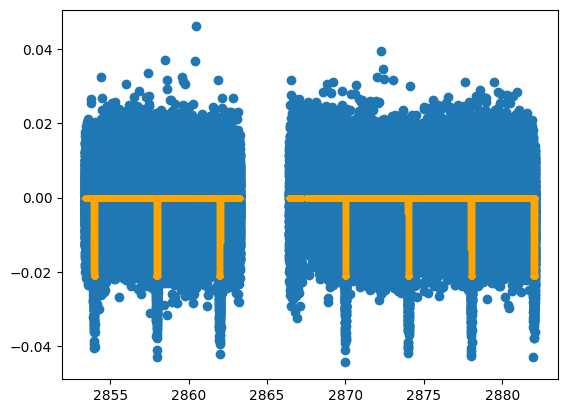

In [63]:
# Again let's set our initial guesses and check how they look
T0 = 0.5*transit_shape_params[0] # This number has to be VERY close to the right number.
ephemeris_initial_guesses = np.array([T0, orbital_period])
initial_guess_transits = fit_transit_ephemeris(time, *ephemeris_initial_guesses)

plt.scatter(time, detrended_flux)
plt.scatter(time, initial_guess_transits, color='orange', marker='.')

[1.86410287 4.008778  ]
best fit T0, period: 1.8641, 4.00878
best fit T0, period unc: 0.00337124, 9.44314e-06


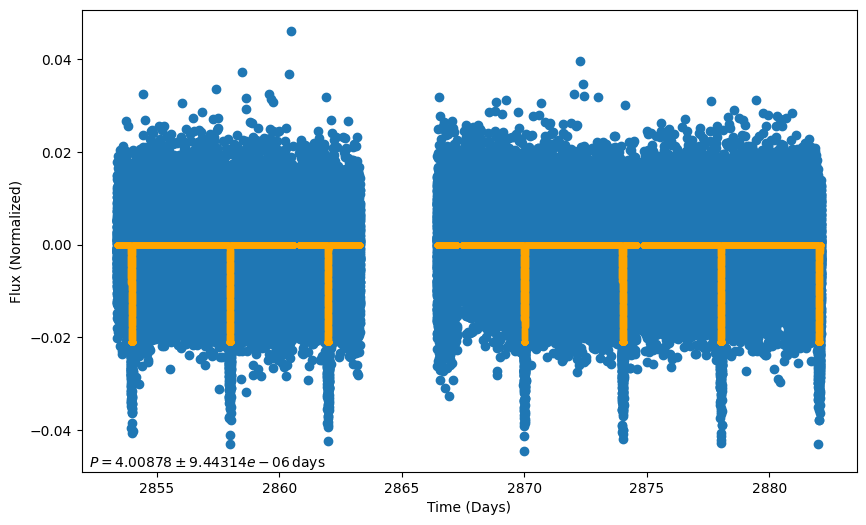

In [69]:
# Now let's do our fit.

ephemeris_fit_params, pcov = curve_fit(fit_transit_ephemeris, time, detrended_flux,
                       p0=ephemeris_initial_guesses, sigma=sigma)
ephemeris_fit_params_unc = np.sqrt(np.diag(pcov))
print(ephemeris_initial_guesses)
print("best fit T0, period: %g, %g" % (ephemeris_fit_params[0], ephemeris_fit_params[1]))
print("best fit T0, period unc: %g, %g" % (ephemeris_fit_params_unc[0], ephemeris_fit_params_unc[1]))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

ax.scatter(time, detrended_flux)
ax.scatter(time, fit_transit_ephemeris(time, *ephemeris_fit_params), color='orange', marker='.')

# Include your final result on the figure
ax.text(0.01, 0.01, r'$P = %g\pm%g\,{\rm days}$' % (ephemeris_fit_params[1], ephemeris_fit_params_unc[1]),
        transform=ax.transAxes)

x_label_text = "Time (Days)" # Label your x-axis
y_label_text = "Flux (Normalized)" # Label your y-axis
ax.set_xlabel(x_label_text)
ax.set_ylabel(y_label_text)

# Save your figure - use another name that describes the data plotted
figure_name = "transit_model.png"
fig.savefig(figure_name, dpi=300, bbox_inches="tight")

In [65]:
n = len(flux)
Uncertainty_calc = (1/np.sqrt(n))*(1/(n-1) * np.sum((flux - np.median(flux))**2)**(0.5))
print("{:e}".format(Uncertainty_calc))

1.726830e-04


In [66]:
Py_unc = ephemeris_fit_params_unc[1]
Pt_unc = 1.9E-7

Pf_unc = np.sqrt((Py_unc**2) + (Pt_unc**2))
print("{:e}".format(Pf_unc))

9.445051e-06


In [67]:
Stellarium_Date = 2460429.64882
T0 = ephemeris_fit_params[0] + 245700
P = ephemeris_fit_params[1]
E = round(((Stellarium_Date - T0) / P))
Tc = T0 + P*E
print(E)
print("Next observable Transit:", Tc)

552470
Next observable Transit: 2460431.44576287
